# Loading the model and setup

In [1]:
import mask_dataset
from config import config
from model import MaskCNN

import os
import random
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
random.seed(config.random_seed)
torch.manual_seed(config.random_seed)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
dataset = mask_dataset.MaskDataset(root_dir='../dataset', img_dim=config.img_dim)

In [5]:
model = MaskCNN(len(dataset.labels), img_dim=config.img_dim, base_filter_size=config.base_filter_size)
model = model.to(device)

In [6]:
# load the model.
model.load_state_dict(torch.load('../trained/MaskCNN_0.pt'))
model.eval()

MaskCNN(
  (classifier): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(384, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 640, kernel_size=(3, 3), s

In [7]:
train_loader, valid_loader = dataset.get_data_loaders(batch_size=config.batch_size, use_shuffle=config.use_shuffle, split_ratio=config.split_ratio)

In [8]:
y_valid_pred = []
y_valid_true = []
y_total_pred = []
y_total_true = []

total = 0
correct = 0

total_per_class = [0, 0, 0, 0, 0]
correct_per_class = [0, 0, 0, 0, 0]

with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)

        out_labels = model(images)
        preds = torch.argmax(out_labels.data, dim=1)
        total += labels.shape[0]
        y_valid_true.extend(labels.data.cpu().numpy())
        y_valid_pred.extend(preds.data.cpu().numpy())
        y_total_true.extend(labels.data.cpu().numpy())
        y_total_pred.extend(preds.data.cpu().numpy())
        correct += (preds == labels).sum().item()
        total_per_class[labels[0]] += labels.shape[0]
        correct_per_class[labels[0]] += (preds == labels).sum().item()

In [9]:
total = np.array(total)
correct = np.array(correct)
print(f'val - accuracy: {np.around(100 * correct / total, 2)}%')

total_per_class = np.array(total_per_class)
correct_per_class = np.array(correct_per_class)
acc_per_class = np.around(100 * correct_per_class / total_per_class, 2)

print('val - per class accuracy:')
for idx, acc in enumerate(acc_per_class):
    print(f' - {dataset.label_to_str[idx]}: {acc}%')

print(f'val - avg accuracy: {np.around(acc_per_class.mean(), 2)}%')

val - accuracy: 80.67%
val - per class accuracy:
 - no-mask: 96.88%
 - surgical: 81.82%
 - cloth: 75.0%
 - n95: 76.56%
 - n95-valve: 73.44%
val - avg accuracy: 80.74%


In [10]:
y_train_pred = []
y_train_true = []

total = 0
correct = 0

total_per_class = [0, 0, 0, 0, 0]
correct_per_class = [0, 0, 0, 0, 0]

with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)

        out_labels = model(images)
        preds = torch.argmax(out_labels.data, dim=1)
        total += labels.shape[0]
        y_train_true.extend(labels.data.cpu().numpy())
        y_train_pred.extend(preds.data.cpu().numpy())
        y_total_true.extend(labels.data.cpu().numpy())
        y_total_pred.extend(preds.data.cpu().numpy())
        correct += (preds == labels).sum().item()
        total_per_class[labels[0]] += labels.shape[0]
        correct_per_class[labels[0]] += (preds == labels).sum().item()

In [11]:
total = np.array(total)
correct = np.array(correct)
print(f'train - accuracy: {np.around(100 * correct / total, 2)}%')

total_per_class = np.array(total_per_class)
correct_per_class = np.array(correct_per_class)
acc_per_class = np.around(100 * correct_per_class / total_per_class, 2)

print('train - per class accuracy:')
for idx, acc in enumerate(acc_per_class):
    print(f' - {dataset.label_to_str[idx]}: {acc}%')

print(f'train - avg accuracy: {np.around(acc_per_class.mean(), 2)}%')

train - accuracy: 100.0%
train - per class accuracy:
 - no-mask: 100.0%
 - surgical: 100.0%
 - cloth: 100.0%
 - n95: 100.0%
 - n95-valve: 100.0%
train - avg accuracy: 100.0%


# Evaluation

## Validation Data

### Confusion Matrix

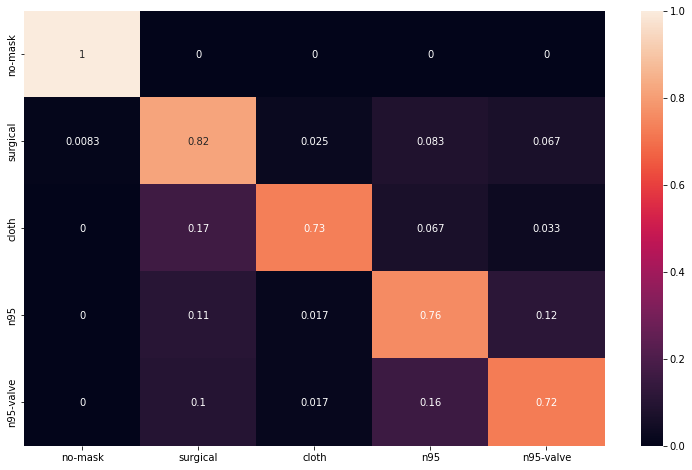

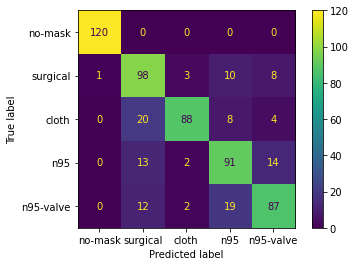

In [12]:
cf_matrix = confusion_matrix(y_valid_true, y_valid_pred)

df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix) * 5, 
    index = [i for i in dataset.labels], 
    columns = [i for i in dataset.labels])
plt.figure(figsize = (13,8))
sn.heatmap(df_cm, annot=True)

# raw values with sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=dataset.labels)
disp.plot()
plt.show()

### Metrics

In [13]:
print(f'accuracy: {accuracy_score(y_valid_true, y_valid_pred):.3f}')
print(f'recall: {recall_score(y_valid_true, y_valid_pred, average="weighted"):.3f}')
print(f'precision: {precision_score(y_valid_true, y_valid_pred, average="weighted"):.3f}')
print(f'f1: {f1_score(y_valid_true, y_valid_pred, average="weighted"):.3f}')

accuracy: 0.807
recall: 0.807
precision: 0.817
f1: 0.808


## Training Data

### Confusion Matrix

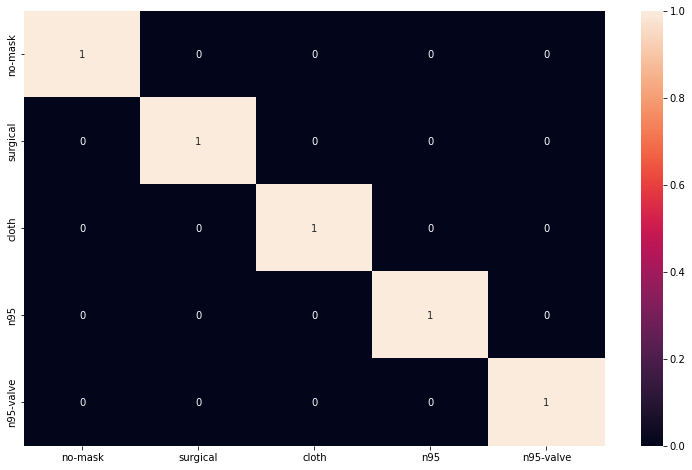

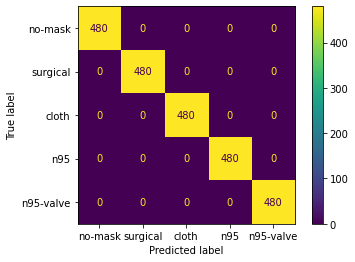

In [14]:
cf_matrix = confusion_matrix(y_train_true, y_train_pred)

df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix) * 5, 
    index = [i for i in dataset.labels], 
    columns = [i for i in dataset.labels])
plt.figure(figsize = (13,8))
sn.heatmap(df_cm, annot=True)

# raw values with sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=dataset.labels)
disp.plot()
plt.show()

### Metrics

In [15]:
print(f'accuracy: {accuracy_score(y_train_true, y_train_pred):.3f}')
print(f'recall: {recall_score(y_train_true, y_train_pred, average="weighted"):.3f}')
print(f'precision: {precision_score(y_train_true, y_train_pred, average="weighted"):.3f}')
print(f'f1: {f1_score(y_train_true, y_train_pred, average="weighted"):.3f}')

accuracy: 1.000
recall: 1.000
precision: 1.000
f1: 1.000


## Whole Dataset

### Confusion Matrix

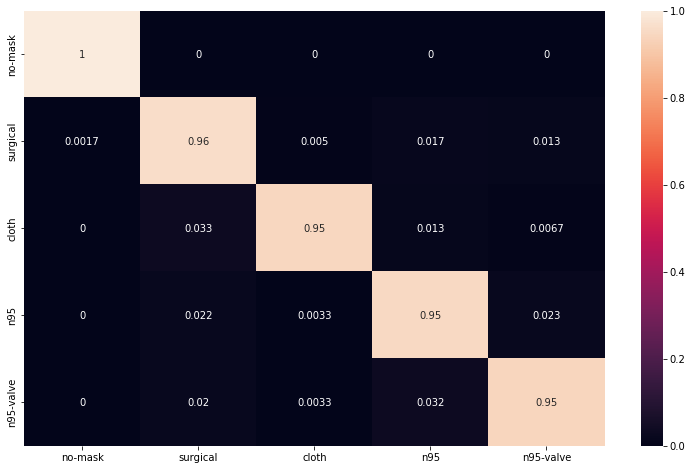

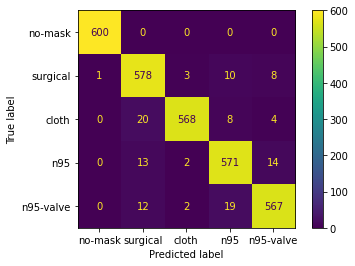

In [16]:
cf_matrix = confusion_matrix(y_total_true, y_total_pred)

df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix) * 5, 
    index = [i for i in dataset.labels], 
    columns = [i for i in dataset.labels])
plt.figure(figsize = (13,8))
sn.heatmap(df_cm, annot=True)

# raw values with sklearn
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=dataset.labels)
disp.plot()
plt.show()

### Metrics

In [17]:
print(f'accuracy: {accuracy_score(y_total_true, y_total_pred):.3f}')
print(f'recall: {recall_score(y_total_true, y_total_pred, average="weighted"):.3f}')
print(f'precision: {precision_score(y_total_true, y_total_pred, average="weighted"):.3f}')
print(f'f1: {f1_score(y_total_true, y_total_pred, average="weighted"):.3f}')

accuracy: 0.961
recall: 0.961
precision: 0.962
f1: 0.961


# Testing with some images

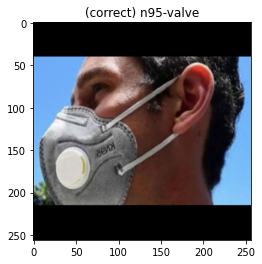

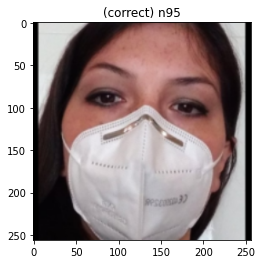

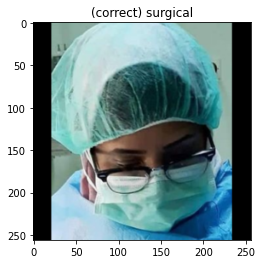

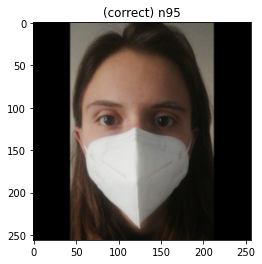

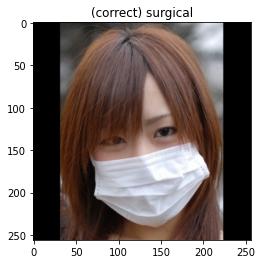

In [18]:
showcase_loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

images, labels = next(iter(showcase_loader))
images, labels = images.to(device), labels.to(device)
preds = torch.argmax(model(images).data, dim=1)
images, labels = images.cpu(), labels.cpu()

for img, label, pred in zip(images, labels, preds):
    if pred == label:
        plt.title(f'(correct) {dataset.label_to_str[label]}')
    else:
        plt.title(f'(wrong) {dataset.label_to_str[pred]} | {dataset.label_to_str[label]} (correct)')
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()